In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines

from pathlib import Path

In [55]:
# === Matplotlib config ===
font = {"family": "DejaVu Sans", "weight": "normal", "size": 15}
plt.set_loglevel("error")
plt.rc("font", **font)
benchmark_color = "#ffb3b3"
fig_dpi = 200

In [56]:
metric_names_backward = {
    'DRAM_bytes': 'dram__bytes.sum',
    'L2_bytes': 'l1tex__t_bytes.sum',
    'L1_bytes': 'lts__t_bytes.sum',
    'cycles_per_s': 'sm__cycles_elapsed.avg.per_second',
    'cycles_elapsed': 'sm__cycles_elapsed.avg',
    'dadd': 'sm__sass_thread_inst_executed_op_dadd_pred_on.sum',
    'dfma': 'sm__sass_thread_inst_executed_op_dfma_pred_on.sum',
    'dmul': 'sm__sass_thread_inst_executed_op_dmul_pred_on.sum',
    'fadd': 'sm__sass_thread_inst_executed_op_fadd_pred_on.sum',
    'ffma': 'sm__sass_thread_inst_executed_op_ffma_pred_on.sum',
    'fmul': 'sm__sass_thread_inst_executed_op_fmul_pred_on.sum',
}

metric_names = {
    v: k for (k, v) in metric_names_backward.items()
}

def empty_metrics(): 
    return {
        k: 0.0 for k in metric_names.values()
    }

In [37]:
def read_metrics(file):
    contents = None
    with open(Path(file), "r") as fd:
        for line in fd:
            if line.startswith("==PROF== Disconnected from process"):
                break
        contents = pd.read_csv(fd)

    if contents is None:
        raise ValueError("Invalid file")

    metrics = empty_metrics()

    total_kernels = 0

    for (i, row) in contents.iterrows():
        metric_name = row['Metric Name']
        metric_val = row['Metric Value']
        if metric_name not in metric_names.keys():
            continue

        short_name = metric_names[metric_name]
        if short_name == 'cycles_per_s':
            total_kernels += 1

        if isinstance(metric_val, str):
            metric_val = float(metric_val.replace(",", ""))
        
        metrics[short_name] += metric_val

    metrics['cycles_per_s'] /= total_kernels

    return metrics

In [52]:
def calc_roofline_metrics(metrics):
    time_s = metrics['cycles_elapsed'] / metrics.get('cycles_per_s', 1.59)
    flops = metrics.get('dfma', 0) + metrics.get('dmul', 0) + metrics.get('dadd',0) + \
            metrics.get('ffma', 0) + metrics.get('fadd', 0) + metrics.get('fmul', 0)

    intensity = {
        key: flops / metrics[f'{key}_bytes'] for key in ['L1', 'L2', 'DRAM']
    }
    
    perf = flops / time_s
    return intensity, perf

def plot_roofline(metrics, names = []):
    flops_h100_sp = 67e12
    flops_h100_dp = 34e12

    bandwidths = {
        'DRAM': 3.35e12,
        'L2': 12e12,
        'L1': 33e12,
    }
    
    fig, ax = plt.subplots(figsize=(6,5))
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel("Arithmetic intensity (FLOPs/Byte)")
    ax.set_ylabel("Performance (TFLOP/second)")

    scale = 1e12

    intensity = 10**np.linspace(-3, 4, 100)

    for key, bandwidth in bandwidths.items():
        max_intensity_sp = flops_h100_sp / bandwidth
        max_intensity_dp = flops_h100_dp / bandwidth
        perf_sp = intensity * bandwidth
        perf_sp[intensity > max_intensity_sp] = flops_h100_sp
        perf_sp /= scale
        ax.plot(intensity, perf_sp, color = 'black')
    
        perf_dp = intensity * bandwidth
        perf_dp[intensity > max_intensity_dp] = flops_h100_dp
        perf_dp /= scale
        ax.plot(intensity, perf_dp, color = 'black')

        ind = 4
        angle = np.rad2deg(np.arctan2(perf_dp[1] - perf_dp[0], intensity[1] - intensity[0]))
        ax.text(
            intensity[ind], perf_dp[ind], f"{key} ({bandwidth / 1e12:.1f} TB/s)",
            ha = 'left', va = 'bottom',
            size = 12,
            rotation = angle,
            rotation_mode='anchor',
            transform_rotates_text=True
        )


    ax.text(
        intensity[-1],
        flops_h100_dp / scale,
        "Double (34 TFLOPs)",
        ha = 'right',
        va = 'bottom',
        size = 12,
    )

    ax.text(
        intensity[-1],
        flops_h100_sp / scale,
        "Single (67 TFLOPs)",
        ha = 'right',
        va = 'bottom',
        size = 12,
    )

    ax.margins(y = 0.1)
    ax.set_xlim(intensity[0], intensity[-1])

    markersize = 8
    
    markers = {
        'L1': 'o',
        'L2': 's',
        'DRAM': 'v',
    }
    scatter_args = {
        's': markersize**2, 'facecolors': 'none'
    }

    # add dummy plots for legend entries
    for (label, marker) in markers.items():
        ax.scatter([10 * intensity[-1]], [flops_h100_sp/scale], edgecolor = 'black', marker=marker, label = label, **scatter_args)

    colors = [f'C{i}' for i in range(len(metrics))]
    
    for (i, metric) in enumerate(metrics):
        intensity, perf = calc_roofline_metrics(metric)
        perf /= scale
        
        intensities = []
        for (key, marker) in markers.items():
            intens = intensity[key]
            intensities.append(intens)
            markersize = 8
            ax.scatter([intens], [perf], edgecolor = colors[i], zorder=5, marker=marker, **scatter_args)

        label = names[i] if len(names) == len(metrics) else ""
        ax.plot(intensities, [perf]*3, zorder=4, color = colors[i]) #, label = label)

    # Add legend for memory
    ax.legend()

    # Add legend for kernels
    handles = [mlines.Line2D([0, 0], [0,0], color=color) for color in colors]
    leg1 = ax.legend(handles, names)
    ax.add_artist(leg1)
    
    ax.legend()

    plt.show()

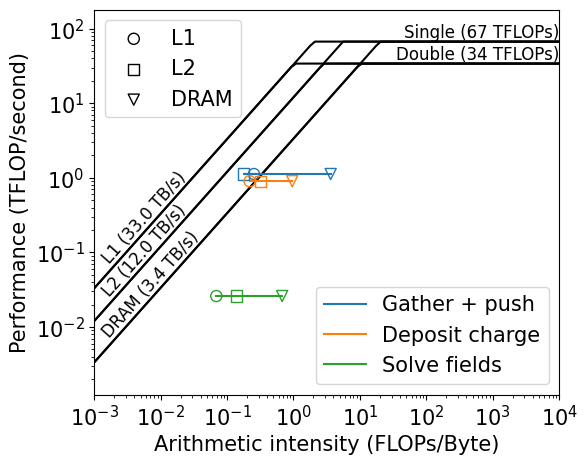

In [53]:
metric_files = [
    'push_1x.csv',
    'deposit_1x.csv',
    'mlmg_1x.csv',
]
metrics = [read_metrics(ncu_dir / file) for file in metric_files]
plot_roofline(metrics, ['Gather + push', 'Deposit charge', 'Solve fields'])